In [90]:
import numpy as np
import scipy.sparse as scsp
import scipy.sparse.linalg as splin
import matplotlib.pyplot as plt
import time
import sksparse.cholmod as chol
np.set_printoptions(precision=2)

In [91]:
def blocktridiaginv(m, bw, nb):
    decomp = chol.cholesky(h, ordering_method="natural")
    L = decomp.L()
    P = decomp.P()
    U = L.toarray().T
#     U = np.linalg.cholesky(h)#.toarray())
    S = np.zeros_like(h.toarray())
    S[-bw:,-bw:] = np.linalg.inv(U[-bw:,-bw:].T @ U[-bw:,-bw:])
    for t in np.arange(nts-2, -1, -1):
        S[t*bw:(t+1)*bw, (t+1)*bw:(t+2)*bw] = - np.linalg.inv(U[t*bw:(t+1)*bw, t*bw:(t+1)*bw]) @ U[t*bw:(t+1)*bw, (t+1)*bw:(t+2)*bw] @ S[(t+1)*bw:(t+2)*bw, (t+1)*bw:(t+2)*bw]
        S[t*bw:(t+1)*bw, t*bw:(t+1)*bw] = np.linalg.inv(U[t*bw:(t+1)*bw, t*bw:(t+1)*bw].T @ U[t*bw:(t+1)*bw, t*bw:(t+1)*bw]) \
                                              - S[t*bw:(t+1)*bw, (t+1)*bw:(t+2)*bw] @ (np.linalg.inv(U[t*bw:(t+1)*bw, t*bw:(t+1)*bw]) @ U[t*bw:(t+1)*bw, (t+1)*bw:(t+2)*bw]).T
        S[(t+1)*bw:(t+2)*bw, t*bw:(t+1)*bw] = S[t*bw:(t+1)*bw, (t+1)*bw:(t+2)*bw].T
    return S#[P[:, np.newaxis], P[np.newaxis, :]]

In [92]:
def logposteriorhessian(y, C, d, A, B, q, q0, m0, u, nts, nn, nsd, nld):
    def f(x):

        Qinv = np.linalg.inv(q)
        Q0inv = np.linalg.inv(q0)
        ATQinvA = A.T @ Qinv @ A
        ATQinvAplusQinv = ATQinvA + Qinv
        ATQinv = A.T @ Qinv

        diag = []
        off_diag = []
        diag.append(scsp.lil_matrix(Q0inv + ATQinvA + sum(np.exp(C[i] @ x[:nld] + d[i]) * np.outer(C[i], C[i].T)
                                          for i in range(nn))))
        for t in range(1, nts-1):
            diag.append(scsp.lil_matrix(sum(np.exp(C[i] @ x[t*nld:(t+1)*nld] + d[i]) * np.outer(C[i], C[i].T)
                                          for i in range(nn)) + ATQinvAplusQinv))
        diag.append(scsp.lil_matrix(Qinv + sum(np.exp(C[i] @ x[-nld:] + d[i]) * np.outer(C[i], C[i].T)
                                          for i in range(nn))))

        for t in range(0, nts-1):
            off_diag.append(scsp.lil_matrix(-ATQinv))

        h = scsp.block_diag(diag).tolil()
        od = scsp.block_diag(off_diag).tolil()

        h[:-nld, nld:] += od
        h[nld:, :-nld] += od.T

        return h.tocsc()
    return f

In [ ]:
nblocks = np.arange(1,400,20)
sparsetimes = np.zeros(len(nblocks))
fulltimes = np.zeros(len(nblocks))
ntrials = 10
blockwidth = 200
for trial in range(1, ntrials):
    blocks = []
    stimes = []
    ftimes = []
    for b in nblocks:
        blocks.append(scsp.coo_matrix(np.random.randn(blockwidth*blockwidth).reshape(-1, blockwidth)))
        sparsematrix = scsp.block_diag(blocks)
        fullmatrix = sparsematrix.toarray()
        vector = np.random.randn(fullmatrix.shape[0])

        tstart = time.clock()
        scsp.spsolve(sparsematrix, vector)
        stimes.append(time.clock() - tstart)

        tstart = time.clock()
        np.linalg.solve(fullmatrix, vector)
        ftimes.append(time.clock() - tstart)
    
    sparsetimes += np.array(stimes)/ntrials
    fulltimes += np.array(ftimes)/ntrials
    
sparseline, = plt.plot(nblocks, sparsetimes, 'b', label="Sparse Solve")
fullline, = plt.plot(nblocks, fulltimes, 'g', label="Full Matrix Solve")
plt.xlabel('N blocks')
plt.ylabel('Computation Time')
plt.legend(handles=[sparseline, fullline])
plt.show()

In [ ]:
fit = np.polyfit(nblocks, sparsetimes, 1)
fit1 = np.poly1d(fit)
sparseline, = plt.plot(nblocks, sparsetimes, 'b', label="Sparse Solve")
polyline, = plt.plot(nblocks, fit1(nblocks), 'g', label="Linear Fit")
plt.xlabel('N blocks')
plt.ylabel('Computation Time')
plt.legend(handles=[sparseline, polyline], loc=2)
plt.show()

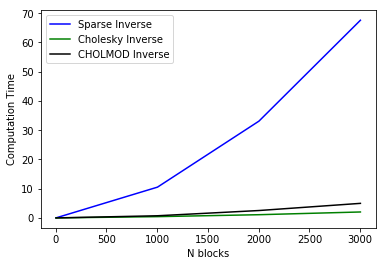

In [99]:
nblocks = np.arange(3,3004, 1000)
sparsetimes = np.zeros(len(nblocks))
choltimes = np.zeros(len(nblocks))
fulltimes = np.zeros(len(nblocks))
cholmodtimes = np.zeros(len(nblocks))
ntrials = 1
bw = 5
for trial in range(1, ntrials+1):
    ctimes = []
    chtimes = []
    stimes = []
    ftimes = []
    for b in nblocks:
        nts = b
        nn = 6
        nld = bw
        nsd = 4
        
        u = np.zeros(nts * nsd)
        C = np.random.randn(nn, nld)
        d = np.random.randn(nn)
        m0 = np.random.rand(nld)
        A = np.random.randn(nld, nld)/2
        q0 = np.identity(nld)
        q = np.identity(nld)
        B = np.zeros((nld, nsd))
        mu = np.random.randn(nld*nts)
        
        Cgen = np.random.randn(nn, nld)/10
        dgen = np.random.randn(nn)/2
        Agen = np.random.randn(nld, nld)/10

        x = np.random.randn(nld)
        y = np.exp(C @ x + d)
        # y = [np.random.poisson(lam=np.exp(C @ x[0] + d))]

        for t in range(nts-1):
            x = np.concatenate([x, Agen @ x[t*nld:(t+1)*nld]])
            y = np.concatenate([y, np.exp(C @ x[(t+1)*nld:(t+2)*nld] + dgen)])
            
        h = logposteriorhessian(y, C, d, A, B, q, q0, m0, u, nts, nn, nsd, nld)(mu)
        
        tstart = time.clock()
        splin.inv(h)
        stimes.append(time.clock() - tstart)

        harr = h.toarray()
#         tstart = time.clock()
#         np.linalg.inv(harr)
#         ftimes.append(time.clock() - tstart)
    
        
        tstart = time.clock()
        blocktridiaginv(h, bw, nts)
        ctimes.append(time.clock() - tstart)
        
        tstart = time.clock()
        chol.cholesky(h).inv()
        chtimes.append(time.clock() - tstart)
        
    sparsetimes += np.array(stimes)/ntrials
#     fulltimes += np.array(ftimes)/ntrials
    choltimes += np.array(ctimes)/ntrials
    cholmodtimes += np.array(chtimes)/ntrials
    
sparseline, = plt.plot(nblocks, sparsetimes, 'b', label="Sparse Inverse")
cholline, = plt.plot(nblocks, choltimes, 'g', label="Cholesky Inverse")
# fullline, = plt.plot(nblocks, fulltimes, 'r', label="Standard Inverse")
cholmodline, = plt.plot(nblocks, cholmodtimes, 'k', label="CHOLMOD Inverse")
plt.xlabel('N blocks')
plt.ylabel('Computation Time')
plt.legend(handles=[sparseline, cholline, cholmodline], loc=2)
plt.show()

In [ ]:
sfit = np.polyfit(nblocks, sparsetimes, 1)
sfit1 = np.poly1d(sfit)
sparseline, = plt.plot(nblocks, sparsetimes, 'b', label="Sparse Inv")
spolyline, = plt.plot(nblocks, sfit1(nblocks), 'g', label="Sparse Linear Fit")

ffit = np.polyfit(nblocks, choltimes, 1)
ffit1 = np.poly1d(ffit)
fullline, = plt.plot(nblocks, choltimes, 'r', label="Cholesky Inv")
fpolyline, = plt.plot(nblocks, ffit1(nblocks), 'k', label="BW Linear Fit")

plt.xlabel('N blocks')
plt.ylabel('Computation Time')
plt.legend(handles=[sparseline, spolyline, fullline, fpolyline], loc=2)
plt.show()

In [ ]:
ffit = np.polyfit(nblocks, fulltimes, 1)
ffit1 = np.poly1d(ffit)
fullline, = plt.plot(nblocks, fulltimes, 'r', label="Block-wise Full Solve")
fpolyline, = plt.plot(nblocks, ffit1(nblocks), 'k', label="BW Linear Fit")

plt.xlabel('N blocks')
plt.ylabel('Computation Time')
plt.legend(handles=[fullline, fpolyline], loc=2)
plt.show()

In [94]:
nts = 3
nn = 2
nld = 2
nsd = 4
y = np.load('../testmats/ygen.npy')
u = np.zeros(nts * nsd)

# Initialize parameters to random values
C = np.random.randn(nn, nld)
d = np.random.randn(nn)
m0 = np.random.rand(nld)
A = np.random.randn(nld, nld)
q0 = np.identity(nld)
q = np.identity(nld)
B = np.zeros((nld, nsd))
mu = np.random.randn(nld*nts) # np.load('../testmats/xgen.npy.npy')

h = logposteriorhessian(y, C, d, A, B, q, q0, m0, u, nts, nn, nsd, nld)(mu)

In [95]:
# print(h.toarray())
print(blocktridiaginv(h, nld, nts))
# print(splin.inv(h).toarray())
print(np.linalg.inv(h.toarray()))
# print(chol.cholesky(h).inv().toarray()[-6:, -6:])

[[  8.52e-02   1.31e-03   4.48e-02  -1.27e-01   0.00e+00   0.00e+00]
 [  1.31e-03   4.41e-01   4.05e-02   2.14e-01   0.00e+00   0.00e+00]
 [  4.48e-02   4.05e-02   2.87e-01  -1.44e-01   7.87e-03  -6.02e-01]
 [ -1.27e-01   2.14e-01  -1.44e-01   9.84e-01   4.60e-02   9.53e-01]
 [  0.00e+00   0.00e+00   7.87e-03   4.60e-02   6.92e-02   3.41e-02]
 [  0.00e+00   0.00e+00  -6.02e-01   9.53e-01   3.41e-02   2.61e+00]]
[[  8.52e-02   1.31e-03   4.48e-02  -1.27e-01  -4.49e-03  -1.69e-01]
 [  1.31e-03   4.41e-01   4.05e-02   2.14e-01   1.39e-02   8.23e-02]
 [  4.48e-02   4.05e-02   2.87e-01  -1.44e-01   7.87e-03  -6.02e-01]
 [ -1.27e-01   2.14e-01  -1.44e-01   9.84e-01   4.60e-02   9.53e-01]
 [ -4.49e-03   1.39e-02   7.87e-03   4.60e-02   6.92e-02   3.41e-02]
 [ -1.69e-01   8.23e-02  -6.02e-01   9.53e-01   3.41e-02   2.61e+00]]


In [58]:
h.toarray()

array([[ 2.12, -0.5 ,  0.47,  0.07,  0.  ,  0.  ],
       [-0.5 ,  6.81, -1.64, -1.66,  0.  ,  0.  ],
       [ 0.47, -1.64,  4.37, -0.83,  0.47,  0.07],
       [ 0.07, -1.66, -0.83,  7.55, -1.64, -1.66],
       [ 0.  ,  0.  ,  0.47, -1.64,  4.3 , -0.81],
       [ 0.  ,  0.  ,  0.07, -1.66, -0.81,  2.06]])

In [85]:
U=chol.cholesky(h, beta=0, ordering_method="natural")

In [86]:
L = U.L().toarray()
P = U.P()

In [87]:
print(h.toarray())
print((L @ L.T))

[[ 13.03  -3.51   2.13   0.57   0.     0.  ]
 [ -3.51  11.93   1.79  -1.28   0.     0.  ]
 [  2.13   1.79  12.39  -2.93   2.13   0.57]
 [  0.57  -1.28  -2.93  11.39   1.79  -1.28]
 [  0.     0.     2.13   1.79  14.18 -18.79]
 [  0.     0.     0.57  -1.28 -18.79  27.8 ]]
[[ 13.03  -3.51   2.13   0.57   0.     0.  ]
 [ -3.51  11.93   1.79  -1.28   0.     0.  ]
 [  2.13   1.79  12.39  -2.93   2.13   0.57]
 [  0.57  -1.28  -2.93  11.39   1.79  -1.28]
 [  0.     0.     2.13   1.79  14.18 -18.79]
 [  0.     0.     0.57  -1.28 -18.79  27.8 ]]


In [84]:
print(P)

[4 5 0 1 2 3]


In [ ]:
L

In [ ]:
h[P[:, np.newaxis], P[np.newaxis, :]].toarray()

In [ ]:
h.toarray()

In [68]:
[P[:, np.newaxis], P[np.newaxis, :]]

[array([[4],
        [5],
        [0],
        [1],
        [2],
        [3]], dtype=int32), array([[4, 5, 0, 1, 2, 3]], dtype=int32)]